# Imports

In [ ]:
!pip install tensorflow_model_optimization

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import ntpath
import os
import pandas as pd
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import time
import warnings
from PIL import Image
from random import randint
from scipy.io import loadmat  
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tqdm.notebook import tqdm, trange
from tensorflow.keras import Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.models import clone_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow_model_optimization.sparsity.keras import ConstantSparsity, prune_low_magnitude, UpdatePruningStep, strip_pruning

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

     |████████████████████████████████| 174kB 4.1MB/s 


# Functions

## print_zeros

In [ ]:
def print_zeros(model):
  """ 
    Print the percentage of zeros in layers of model

    Parameters: 
    model : the model to analyze
  
  """
  for layer in model.layers:
    if isinstance(layer, Conv2D):
      if not 'depthwise' in layer.name:
        w = layer.get_weights()[0]
        print("{} - Zeros: {:.2f}%".format(layer.name, np.sum(w == 0) / w.size * 100))
    if isinstance(layer, Dense):
      print("{} - Zeros: {:.2f}%".format(layer.name, np.sum(w == 0) / w.size * 100))

## plot_training_epochs

In [ ]:
def plot_training_epochs(name, net, hist, es):
  """ 
    Plot the training and the validation loss and accuracy (top-1, top-3, top-5)
    through training epochs.
  
    Parameters: 
    name : name for the output file
    net : name for plot title
    hist : training history
    es : EarlyStopping callback
  
  """

  # loss plot
  plt.title(net + " loss")
  plt.plot(hist.history['val_loss'], color = 'orange')
  plt.plot(hist.history['loss'], color = 'blue')
  plt.xlabel('epoch')
  plt.ylabel('categorical cross entropy')
  if es.stopped_epoch != 0:
    plt.axvline(x=es.stopped_epoch, color='gray', lw=1.5, ls='--', label='stopped epoch')
  plt.xticks(np.arange(0,10,1), np.arange(1,11,1))
  plt.xlim(0,9)
  plt.legend(['Validation','Training', 'Stopped epoch'],loc="upper right")
  plt.savefig(name + '-loss.eps', format='eps', dpi=600)
  
  # top-1, top-3, top-5 accuracy plots
  fig , axes = plt.subplots(1, 3, figsize=(14,4))

  fig.suptitle(net + ' accuracy', fontsize=20)

  axes[0].title.set_text("Top 1")
  axes[0].plot(hist.history['val_categorical_accuracy'], color='red')
  axes[0].plot(hist.history['categorical_accuracy'], color='green')
  axes[0].set_ylim([0,1])
  axes[0].set_xlabel('epoch')
  axes[0].set_ylabel('accuracy')
  if es.stopped_epoch != 0:
    axes[0].axvline(x=es.stopped_epoch, color='gray', lw=1.5, ls='--', label='stopped epoch')
  axes[0].set_yticks(np.arange(0,1.1,0.1))
  axes[0].set_xticks(np.arange(0,10,1))
  axes[0].set_xticklabels(np.arange(1,11,1))
  axes[0].set_xlim(0,9)
  axes[0].legend(['Validation','Training', 'Stopped epoch'],loc="lower right")

  axes[1].title.set_text("Top 3")
  axes[1].plot(hist.history['val_top_3_categorical_accuracy'], color='red')
  axes[1].plot(hist.history['top_3_categorical_accuracy'], color='green')
  axes[1].set_ylim([0,1])
  axes[1].set_xlabel('epoch')
  axes[1].set_ylabel('accuracy')
  if es.stopped_epoch != 0:
    axes[1].axvline(x=es.stopped_epoch, color='gray', lw=1.5, ls='--', label='stopped epoch')
  axes[1].set_yticks(np.arange(0,1.1,0.1))
  axes[1].set_xticks(np.arange(0,10,1))
  axes[1].set_xticklabels(np.arange(1,11,1))
  axes[1].set_xlim(0,9)
  axes[1].legend(['Validation','Training', 'Stopped epoch'],loc="lower right")
  

  axes[2].title.set_text("Top 5")
  axes[2].plot(hist.history['val_top_5_categorical_accuracy'], color='red')
  axes[2].plot(hist.history['top_5_categorical_accuracy'], color='green')
  axes[2].set_ylim([0,1])
  axes[2].set_xlabel('epoch')
  axes[2].set_ylabel('accuracy')
  if es.stopped_epoch != 0:
    axes[2].axvline(x=es.stopped_epoch, color='gray', lw=1.5, ls='--', label='stopped epoch')
  axes[2].set_yticks(np.arange(0,1.1,0.1))
  axes[2].set_xticks(np.arange(0,10,1))
  axes[2].set_xticklabels(np.arange(1,11,1))
  axes[2].set_xlim(0,9)
  axes[2].legend(['Validation','Training', 'Stopped epoch'],loc="lower right")

  fig.tight_layout(rect=[0, 0.03, 1, 0.92])

  fig.savefig(name + '-accuracy.eps', format='eps', dpi=600)

## params_per_layer

In [ ]:
def params_per_layer(model):
  """ 
    Print the number and the percentage of parameters for each layer of the 
    model.
  
    Parameters: 
    model : the model to analyze
  
  """
  types=[]
  for layer in model.layers:
    if layer.__class__.__name__ not in types:
      types.append(layer.__class__.__name__)
  sum_layers=[]
  for i, layer_type in enumerate(types):
    sum=0 
    for layer in model.layers:
      if (layer.__class__.__name__==layer_type):
        sum=sum + layer.count_params()
    sum_layers.append(sum)
  perc=np.around(np.array(sum_layers)/model.count_params()*100,2)
  print(pd.DataFrame(list(zip(sum_layers, perc)), index=types, columns=['Total', 'Total%']))

## prune_net

In [ ]:
def prune_net(model_to_prune, max_sparsity):
  """ 
    Applies iterative pruning to model (magnitude based). 
  
    Parameters: 
    model_to_prune : the model to prune
    max_sparsity : max sparsity to reach (6=60%)
  
  """
  scores = []
  # Evaluating base model
  print('evaluating base')
  score_init = model_to_prune.evaluate(test_generator,
                                       verbose=1, 
                                       batch_size=64, 
                                       steps=1638/64)
  scores.append(score_init)
  model_for_pruning = None
  # Print percentage of zeros per layer
  print_zeros(model_to_prune)
  print('\n')
  # For each sparsity 0.1, 0.2, ..., max_sparsity evaluate the model obtained
  for i in [round(x*0.1,2) for x in range(1,max_sparsity+1)]:
    print("pruning parameters {}%".format(i*100))
    # Used to prune only convolutional layers (no depthwise) or dense layers
    def apply_pruning(layer):
      pruning_params = {
          'pruning_schedule': ConstantSparsity(i,0)
      }
      if (isinstance(layer, Conv2D) and not 'depthwise' in layer.name) or isinstance(layer, Dense):
        return prune_low_magnitude(layer, **pruning_params)
      else:
        return layer
    # If it is the first iteration clone the model given as argument
    if i==0.1:
      model_for_pruning = clone_model(
        model_to_prune,
        clone_function=apply_pruning,
      ) 
    # Otherwise clone the model obtained in the iteration before
    else:
      model_for_pruning = clone_model(
        final_model,
        clone_function=apply_pruning,
      )
      del final_model
    # Compile pruned model
    model_for_pruning.compile(
        optimizer=Adam(learning_rate=0.002),
        loss='categorical_crossentropy',
        metrics=[CategoricalAccuracy(name="categorical_accuracy"),
                 TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy'),
                 TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')
        ]
      )
    es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', min_delta=.02, patience=2, restore_best_weights=True)
    print('training')
    # Train pruned model
    hist = model_for_pruning.fit(train_generator,
                    validation_data=val_generator,
                    batch_size=64,
                    validation_batch_size=64,
                    steps_per_epoch=5284/64,
                    validation_steps=1267/64,
                    epochs=10,
                    callbacks=[es,
                               UpdatePruningStep()],
                    class_weight=class_weights)
    # Evaluate pruned and trained model
    final_model = strip_pruning(model_for_pruning)
    final_model.compile(
        optimizer=Adam(learning_rate=0.002),
        loss='categorical_crossentropy',
        metrics=[CategoricalAccuracy(name="categorical_accuracy"),
                 TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy'),
                 TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')
      ]
    )
    # Print the percentage of zeros reached
    print_zeros(final_model)
    print('evaluating')
    score_pruned = final_model.evaluate(test_generator,
                                        verbose=1, 
                                        batch_size=64, 
                                        steps=1638/64)
    # Save the pruned model obtained
    final_model.save(model_to_prune.name+str(round(i*100))+'.h5')
    scores.append(score_pruned)
    print('\n')
  return scores

##plot_models_comparison

In [ ]:
def plot_models_comparison(names, *scores):
  """ 
    Plot accuracy values obtained by different models on the same test set.
  
    Parameters: 
    names (string): names of different models
    *score : list of score lists obtained by model.evaluate
  
  """
  accuracy = [x[1] for x in scores]
  accuracy3 = [x[2] for x in scores]
  accuracy5 = [x[3] for x in scores]
  dataframe = pd.DataFrame(list(zip(accuracy, accuracy3, accuracy5)), 
                           columns=['Top 1', 'Top 3', 'Top 5'],
                           index=names)
  dataframe = dataframe.transpose()
  fig = dataframe.plot.bar(rot=0, figsize=(8,4))
  fig.grid(axis='x')
  fig.set_ylabel('accuracy')
  fig.set_ylim([0.8,1.05])
  fig.legend(names, loc='lower right')
  fig.set_title('Performance of models')
  for p in fig.patches:
    fig.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() + 0.005))
  fig.get_figure().savefig('performance-test.eps', format='eps', dpi=600)

##model_to_TFlite_float32

In [ ]:
def model_to_TFlite_float32(model,new_model_path):
  """
    Convert a model.h5 in a model.tflite
    In this way run the pruning and the quantization on the model the size decrease and the accuracy is kept

    Parameters:
    model: model to convert
    new_model_path: directory where the new model.tflite will be stored

  """
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  quantized_and_pruned_tflite_model = converter.convert()

  with tf.io.gfile.GFile(new_model_path, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model) 

##model_to_TFlite_dynamic

In [ ]:
def model_to_TFlite_dynamic(model,new_model_path):
  """
    Convert a model.h5 in a model.tflite
    In this way run the pruning on the model the size decrease and the accuracy is kept

    Parameters:
    model: model to convert
    new_model_path: directory where the new model.tflite will be stored

  """
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  pruned_tflite_model = converter.convert()

  with tf.io.gfile.GFile(new_model_path, 'wb') as f:
    f.write(pruned_tflite_model)

## model_to_TFlite_float16

In [ ]:
def model_to_TFlite_float16(model,new_model_path):
  """
    Convert a model.h5 in a model.tflite
    In this way run the pruning on the model the size decrease and the accuracy is kept

    Parameters:
    model: model to convert
    new_model_path: directory where the new model.tflite will be stored

  """
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.target_spec.supported_types = [tf.float16]
  pruned_tflite_model = converter.convert()

  with tf.io.gfile.GFile(new_model_path, 'wb') as f:
    f.write(pruned_tflite_model)

##tflite_performance

In [ ]:
def tflite_performance(model_path, test, preprocess):

  """
    Evaluate the performances accuracy, top3_accuracy, top5_accuracy of a model.tflite

    Parameters:
    model_path: where the model.tflite has been stored
    test: a Pandas.DataFrame that contain two columns ['file_name','label']
          - file_name is the path of a image tensor to load with load_img

    return accuracy, top3_accuracy, top5_accuracy
  """

  times=[]

  # Load TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_path)
  interpreter.allocate_tensors()

  print("Interpreter allocate...")
  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  #prediction_list = []
  prediction = []
  prediction3 = []
  prediction5 = []
  print("Start evaluation...")
  # Test model.tflite on test data.

  n_data = test.shape[0]

  for i in trange(n_data):        
    test_image = test.filename.iloc[i]  
    test_label = test.label.iloc[i]

    img_path = "/content/"+test_image

    img_random = tf.keras.preprocessing.image.load_img(img_path, target_size = (224, 224))
    img_random = tf.keras.preprocessing.image.img_to_array(img_random)
    #img_random = img_random / 255
    img_random = preprocess(img_random)
    img_random = img_random.reshape(1,224,224,3)
    #print("dim: ",img_random.shape)
    #print("dtype image", img_random.dtype)
    #plt.imshow(img_random.reshape(224,224,3), cmap=plt.cm.binary)

    
    interpreter.set_tensor(input_details[0]['index'], img_random)
    
    start_time = time.time()
    interpreter.invoke()
    execution_time = time.time() - start_time 
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    top_probs, top_idxs = tf.math.top_k(input=output_data[0], k=5)
    times.append(execution_time)
    indici = np.array(top_idxs, dtype=int) 

    #print("\nImage label:\t", test_label)
    #print("\nLabel before:\t",(indici))
    labels_pred = []
    for item in indici:
      labels_pred.extend(dictionary_ind[item])
    
    labels_pred = np.array(labels_pred, dtype='int64')
    #print("Label after:\t", labels_pred)


    if (labels_pred[0] == test_label ):
      prediction.append(1)
    else:
      prediction.append(0)

    if (test_label in labels_pred[0:3]):
      prediction3.append(1)
    else:
      prediction3.append(0)

    if (test_label in labels_pred[0:5]):
      prediction5.append(1)
    else:
      prediction5.append(0)
    
  top1 = prediction.count(1)/len(prediction)
  top3 = prediction3.count(1)/len(prediction3)
  top5 = prediction5.count(1)/len(prediction5)

  return top1, top3, top5, np.mean(np.array(times))

##plot_quantization_size

In [ ]:
def plot_quantization_size(labels, mobilenet, densenet, efficientnet, name):
  """
    Plot the size of the models.h5 and the models.tflite
    
    Parameters: 
      labels: list of name under the plt.bar
      normal: list of models.h5 attribute
      float16: list of models.tflite attribute
      dynamic: list of models.tflite attribute
      string: attribute that you want compare
      unit: unit of the ylabel
      name: name of the chart

  """
  dataframe = pd.DataFrame(list(zip(mobilenet, densenet, efficientnet)), 
                           columns=labels,
                           index=labels)
  dataframe = dataframe.transpose()
  fig = dataframe.plot.bar(rot=0, figsize=(8,4))
  fig.grid(axis='x')
  fig.set_ylabel('Size (MB)')
  fig.set_ylim([0,30])
  fig.legend(['Float32', 'Float16', 'Dynamic range'], loc='upper left')
  fig.set_title('Size of models')
  fig.get_figure().savefig(name, format='eps', dpi=600)

##plot_predict_image

In [ ]:
def plot_predict_image(img_path, model, preprocess_input, k, dictionary, name):
  """
    Plot image predictions

    Parameters:
      img_path: image to predict
      model: who predict
      preprocess_input: function use in the preprocess
      k: how many result plot
      dictionary: reference between prediction and labels
      name: name to store the chart
  """

  print(model.name)
  plot_img = tf.keras.preprocessing.image.load_img(img_path, target_size = (224, 224))

  img = tf.keras.preprocessing.image.load_img(img_path, target_size = (224, 224))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img_pre = preprocess_input(img)
  

  prediction = model.predict(img_pre)
  top_probs, top_idxs = tf.math.top_k(input=prediction, k=k)
  print("Probabilità: \t",top_probs.numpy())
                                              
  indici = np.array(top_idxs, dtype=int)
  indices = []

  for item in indici[0]:
    indices.extend(dictionary[item])

  indici = np.array(indices, dtype=int)

  print("indici: \t", indici)
  pred_label = []
  for i in indici:
    pred_label.append(labels_name[i])
  print(pred_label)
  fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
  fig.suptitle('Prediction example')
  ax1.imshow(plot_img, cmap=plt.cm.binary)
  ax1.grid(False)

  for label, prob in zip(pred_label, top_probs[0]):
    ax2 = plt.barh(label, prob)

  plt.tight_layout()
  plt.savefig(name, dpi=600)

##modified_preprocess

In [ ]:
def modified_preprocess(x, data_format=None, mode='caffe', **kwargs):
  """ 
    Extend the original preprocessing function used in the ImageDataGenerator.
    In this way the same preprocessing function can be used for different models
    . The parameter mode is based on the value of the global variable 'net'. 
  
    Parameters: 
    x: image tensor
    data_format: Data format of the image tensor/array.
    mode: One of "caffe", "tf" or "torch".
            - caffe: will convert the images from RGB to BGR,
                then will zero-center each color channel with
                respect to the ImageNet dataset,
                without scaling.
            - tf: will scale pixels between -1 and 1,
                sample-wise.
            - torch: will scale pixels between 0 and 1 and then
                will normalize each channel with respect to the
                ImageNet dataset.
  
  """
  # mobilenet uses 'tf' mode
  if net=='mobilenet':
    return preprocess_input(x, data_format, 'tf', **kwargs)
  # densenet use 'torch' mode
  elif net=='densenet':
    return preprocess_input(x, data_format, 'torch', **kwargs)
  # efficientnet preprocessing is included as layer in the net
  elif net=='efficientnet':
    return x

##plot_training_class_distribution

In [ ]:
def plot_training_class_distribution(labels, path):
  """
    Plot training set class distribution

    Parameters:
      labels: list of training set labels
      path: where to save plot image 
  """
  labels_plot = np.array(labels)
  labels_count = np.unique(labels_plot, return_counts=True)
  plt.figure(figsize=(10,4))
  plt.bar(labels_count[0], labels_count[1], width=0.5)
  plt.title('Training set class distribution')
  plt.grid(axis='x')
  plt.xlabel('class')
  plt.ylabel('count')
  plt.xlim(-1,102)
  plt.xticks(np.arange(0,102,5))
  plt.tight_layout()
  plt.savefig(path, format='eps', dpi=600)

##reverse_dict

In [ ]:
def reverse_dict(train_generator):
  """
    Create a reversed reference between train_generator indices and the labels

    Parameters:
      train_generator: ImageDataGenerator used for training
  """
  dictionary_ind = {}
  for k,v in train_generator.class_indices.items():
      if v in dictionary_ind:
          dictionary_ind[v].append(k)
      else:
          dictionary_ind[v] = [k]
  return dictionary_ind

##plot_accuracy_sparsity_curve

In [ ]:
def plot_accuracy_sparsity_curve(scores, name, path):
  """
    Plot accuracy_sparsity curve

    Parameters:
      scores: accuracy scores obtained during iterative pruning
      path: where to save plot image 
  """
  loss_accuracy = [x[1]-scores[0][1] for x in scores]
  loss_accuracy_3 = [x[2]-scores[0][2] for x in scores]
  loss_accuracy_5 = [x[3]-scores[0][3] for x in scores]
  plt.plot(loss_accuracy)
  plt.plot(loss_accuracy_3)
  plt.plot(loss_accuracy_5)
  plt.ylim(-0.2,0.1)
  plt.xticks(np.arange(7), labels=['0','10', '20', '30', '40', '50', '60'])
  plt.xlabel('pruned parameters (%)')
  plt.yticks(np.round(np.arange(-0.2, 0.2, 0.05), 2), labels=['-20', '-15', '-10', '-5', '0', '+5', '+10', '+15'])
  plt.ylabel('accuracy loss (%)')
  plt.legend(['Top 1', 'Top 3', 'Top 5'])
  plt.title(net + ' pruning effect')
  plt.savefig(path, format='eps', dpi=600)

# Dataset

## Download images

In [ ]:
# Download dataset
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!mkdir flowers/
!tar zxvf 102flowers.tgz -C flowers/
!rm 102flowers.tgz

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat 

In [ ]:
# Download labels
data = loadmat('imagelabels.mat')
labels = data['labels'][0].tolist()
labels = [label - 1 for label in labels]

In [ ]:
!rm imagelabels.mat
!wget https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt

In [ ]:
# Download labels name
f = open("Oxford-102_Flower_dataset_labels.txt", 'r')
labels_name = f.read() 
f.close()
labels_name = labels_name.split('\n')
labels_name = [label[1:].strip('"').strip("'") for label in labels_name]

In [ ]:
!rm Oxford-102_Flower_dataset_labels.txt

## Create dataset

In [ ]:
# Train-test split
filenames = sorted(glob.glob("flowers/jpg/*.jpg"))
X_train, X_test, Y_train, Y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42)

In [ ]:
# Plot training set class distribution
plot_training_class_distribution(labels, 'training-distribution.eps')

In [ ]:
# Save training and test datasets as .csv
train_df = pd.DataFrame(list(zip(X_train,Y_train)), columns=['filename','label'])
train_df.to_csv('train.csv')
test_df = pd.DataFrame(list(zip(X_test,Y_test)), columns=['filename','label'])
test_df.to_csv('test.csv')

## Load dataset

In [ ]:
# Load training and test datasets from .csv
train_df = pd.read_csv('/content/train.csv', index_col=0)
test_df = pd.read_csv('/content/test.csv', index_col=0)

In [ ]:
X_train = train_df['filename'].tolist()
Y_train = train_df['label'].tolist()
X_test = test_df['filename'].tolist()
Y_test = test_df['label'].tolist()

##Make dataset

In [ ]:
!mkdir -p datasets/train/

In [ ]:
# Create training set directory
new_filenames_train = []

# Create folder for each class
for label in labels:
  folder = r"datasets/train/" + str(label)
  if not os.path.exists(folder):
    os.mkdir(folder)

# Move images in the appropriate folder
failed = 0
for i, image in enumerate(X_train):
  head, tail = ntpath.split(image)
  filename = r"datasets/train/{}/{}".format(str(Y_train[i]), tail)
  new_filenames_train.append(filename)
  if not os.path.exists(filename):
    try:
      os.rename(image, filename)
    except:
      failed +=1
    
print('failed on {} files'.format(failed))

train = pd.DataFrame({
    'filename' : new_filenames_train,
    'label' : Y_train
})


failed on 0 files


In [ ]:
!mkdir -p datasets/test/

In [ ]:
# Create test set directory
new_filenames_test = []

# Create folder for each class
for label in labels:
  folder = r"datasets/test/" + str(label)
  if not os.path.exists(folder):
    os.mkdir(folder)

# Move images in the appropriate folder
failed = 0
for i, image in enumerate(X_test):
  head, tail = ntpath.split(image)
  filename = r"datasets/test/{}/{}".format(str(Y_test[i]), tail)
  new_filenames_test.append(filename)
  if not os.path.exists(filename):
    try:
      os.rename(image, filename)
    except:
      failed +=1
    
print('failed on {} files'.format(failed))

test = pd.DataFrame({
    'filename' : new_filenames_test,
    'label' : Y_test
})

failed on 0 files


In [ ]:
!rm -r flowers

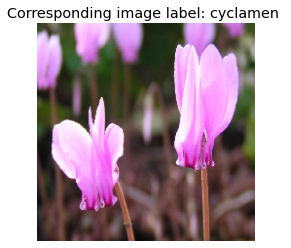

In [ ]:
# Random image test
index = randint(0, len(train))
plt.figure()
plt.imshow(load_img(train['filename'][index], target_size=(224,224)))
plt.title('Corresponding image label: {}'.format(labels_name[train['label'][index]]))
plt.axis('off')
plt.show()

## Data augmentation example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


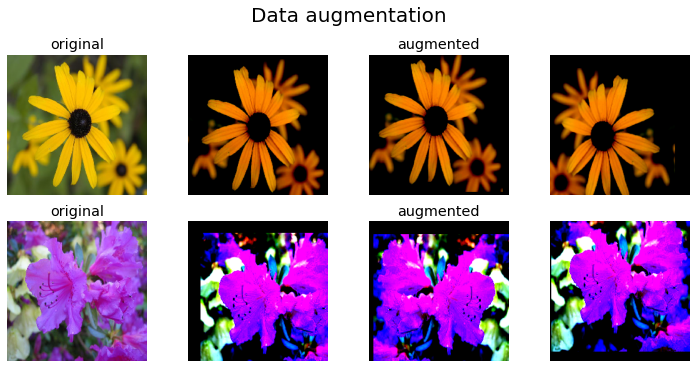

In [ ]:
# Plot data augmentation examples. First image is preprocessed with MobileNetV2
# preprocessing, while the second with DenseNet preprocessing.
img = load_img('/content/datasets/test/62/image_05851.jpg', target_size=(224,224))  
img = img_to_array(img)

img1 = load_img('/content/datasets/test/71/image_03545.jpg', target_size=(224,224))  
img1 = img_to_array(img1)

fig = plt.figure(constrained_layout=True, figsize=(10,5))
gs = fig.add_gridspec(2, 4)
fig.suptitle('Data augmentation', size=20)

original = fig.add_subplot(gs[0, 0])
original.set_title('original')
original.axis('off')
original.imshow(img/255)

original1 = fig.add_subplot(gs[1, 0])
original1.set_title('original')
original1.axis('off')
original1.imshow(img1/255)

img = np.expand_dims(img, axis=0)
img1 = np.expand_dims(img1, axis=0)

# global variable for modified_preprocess input
net='mobilenet'

aug_datagen = ImageDataGenerator(
        validation_split=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15,
        horizontal_flip=True,
        preprocessing_function=modified_preprocess,
        cval=0,
        fill_mode='constant')

augmented = aug_datagen.flow(img, batch_size=1)

augmented_imgs = []
for i in range(0,3):
  augmented_imgs.append(next(augmented)[0])

aug1 = fig.add_subplot(gs[0,1])
aug1.axis('off')
aug1.imshow(augmented_imgs[0])

aug2 = fig.add_subplot(gs[0,2])
aug2.axis('off')
aug2.set_title('augmented')
aug2.imshow(augmented_imgs[1])

aug3 = fig.add_subplot(gs[0,3])
aug3.axis('off')
aug3.imshow(augmented_imgs[2])

# global variable for modified_preprocess input
net='densenet'

augmented2 = aug_datagen.flow(img1, batch_size=1)

augmented_imgs1 = []
for i in range(0,3):
  augmented_imgs1.append(next(augmented2)[0])

aug4 = fig.add_subplot(gs[1,1])
aug4.axis('off')
aug4.imshow(augmented_imgs1[0])

aug5 = fig.add_subplot(gs[1,2])
aug5.set_title('augmented')
aug5.axis('off')
aug5.imshow(augmented_imgs1[1])

aug6 = fig.add_subplot(gs[1,3])
aug6.axis('off')
aug6.imshow(augmented_imgs1[2])

fig.savefig('data-augmentation.png', format='png', dpi=600)

## Generators

In [ ]:
# Train generator
train_datagen = ImageDataGenerator(
        validation_split=0.2,
        width_shift_range=0.10,
        height_shift_range=0.10,
        horizontal_flip=True,
        brightness_range=[0.95,1.05],
        preprocessing_function=modified_preprocess,
        cval=0,
        fill_mode='constant')

train_generator = train_datagen.flow_from_directory(
        'datasets/train',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical',
        shuffle=True,
        seed=42,
        subset='training')

Found 5284 images belonging to 102 classes.


In [ ]:
# Validation generator
val_generator = train_datagen.flow_from_directory(
        'datasets/train',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical',
        shuffle=True,
        seed=42,
        subset='validation')

Found 1267 images belonging to 102 classes.


In [ ]:
# Test generator
test_datagen = ImageDataGenerator(
        preprocessing_function=modified_preprocess)

test_generator = test_datagen.flow_from_directory(
        'datasets/test',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical')

test_generator.reset()

Found 1638 images belonging to 102 classes.


#Architectures

In [ ]:
# Class weights for a 'balanced' training
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
class_weights = dict(zip(np.unique(Y_train), class_weights))

In [ ]:
# create reversed dictionary
dictionary_ind = reverse_dict(train_generator)

## MobileNet V2

In [ ]:
# Global variable for modified_preprocess_function
net='mobilenet'

### MobileNet V2 with $\alpha=0.5$

In [ ]:
# Build
base = MobileNetV2(input_shape=(224,224,3),
                   include_top=False, 
                   weights='imagenet',
                   alpha=0.5,
                   pooling='avg')

base.trainable=False
base_output = base.output
dropout = Dropout(rate=0.5) (base_output)
dense = Dense(102, activation='softmax') (dropout)

mobilenet05 = Model(inputs=base.input, outputs=dense)
mobilenet05.summary()

# Compile
mobilenet05.compile(
    optimizer=Adam(learning_rate=0.002),
    loss='categorical_crossentropy',
    metrics=[CategoricalAccuracy(name="categorical_accuracy"),
             TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy'),
             TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')]
  )

# Train
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', min_delta=.01, patience=3, restore_best_weights=True)
hist = mobilenet05.fit(train_generator,
                    validation_data=val_generator,
                    batch_size=64,
                    validation_batch_size=64,
                    steps_per_epoch=5284/64,
                    validation_steps=1267/64,
                    epochs=10,
                    callbacks=es,
                    class_weight=class_weights)

# Plot performance
plot_training_epochs('mobilenet05', 'MobileNetV2', hist, es)

# Evaluate
mobilenet05_score = mobilenet05.evaluate(test_generator, verbose=1, batch_size=64, steps=1638/64)

In [ ]:
plot_predict_image('/content/datasets/test/33/image_06932.jpg', mobilenet05, modified_preprocess, 5, dictionary_ind, "predict_by_mobilenet05")

### MobileNet V2 with $\alpha=0.75$

In [ ]:
# Build
base = MobileNetV2(input_shape=(224,224,3),
                   include_top=False, 
                   weights='imagenet',
                   alpha=0.75,
                   pooling='avg')

base.trainable=False
base_output = base.output
dropout = Dropout(rate=0.5) (base_output)
dense = Dense(102, activation='softmax') (dropout)

mobilenet75 = Model(inputs=base.input, outputs=dense)
mobilenet75.summary()

# Compile
mobilenet75.compile(
    optimizer=Adam(learning_rate=0.002),
    loss='categorical_crossentropy',
    metrics=[CategoricalAccuracy(name="categorical_accuracy"),
             TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy'),
             TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')]
  )

# Train
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', min_delta=.01, patience=3, restore_best_weights=True)
hist = mobilenet75.fit(train_generator,
                    validation_data=val_generator,
                    batch_size=64,
                    validation_batch_size=64,
                    steps_per_epoch=5284/64,
                    validation_steps=1267/64,
                    epochs=10,
                    callbacks=es,
                    class_weight=class_weights)

# Plot performance
plot_training_epochs('mobilenet75', 'MobileNetV2', hist, es)
print()
# Evaluate
mobilenet75_score = mobilenet75.evaluate(test_generator, verbose=1, batch_size=64, steps=1638/64)

In [ ]:
plot_predict_image('/content/datasets/test/5/image_07180.jpg', mobilenet75, modified_preprocess, 5, dictionary_ind, "predict_by_mobilenet75")

### MobileNet V2 with $\alpha=1$

In [ ]:
# Build
base = MobileNetV2(input_shape=(224,224,3),
                   include_top=False, 
                   weights='imagenet',
                   pooling='avg')

base.trainable=False
base_output = base.output
dropout = Dropout(rate=0.5) (base_output)
dense = Dense(102, activation='softmax') (dropout)

mobilenet1 = Model(inputs=base.input, outputs=dense)
mobilenet1.summary()

# Compile
mobilenet1.compile(
    optimizer=Adam(learning_rate=0.002),
    loss='categorical_crossentropy',
    metrics=[CategoricalAccuracy(name="categorical_accuracy"),
             TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy'),
             TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')]
  )

# Train
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', min_delta=.01, patience=3, restore_best_weights=True)
hist = mobilenet1.fit(train_generator,
                    validation_data=val_generator,
                    batch_size=64,
                    validation_batch_size=64,
                    steps_per_epoch=5284/64,
                    validation_steps=1267/64,
                    epochs=10,
                    callbacks=es,
                    class_weight=class_weights)

# Plot performance
plot_training_epochs('mobilenet1', 'MobileNetV2', hist, es)
print()
# Evaluate
mobilenet1_score = mobilenet1.evaluate(test_generator, verbose=1, batch_size=64, steps=1638/64)

In [ ]:
plot_predict_image('/content/datasets/test/5/image_07180.jpg', mobilenet1, modified_preprocess, 5, dictionary_ind, "predict_by_mobilenet1")

### Mobilenet V2 comparison

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


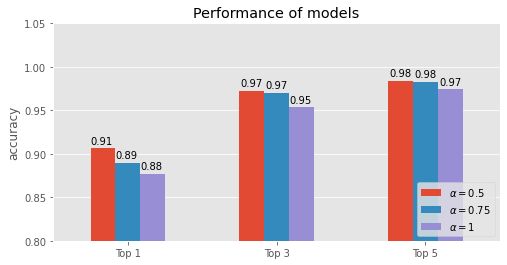

In [ ]:
# Compare models performance
plot_models_comparison([r'$\alpha=0.5$', r'$\alpha=0.75$', r'$\alpha=1$'], mobilenet05_score, mobilenet75_score, mobilenet1_score)

### Model Save

In [ ]:
mobilenet05.save('mobilenet05.h5')
mobilenet75.save('mobilenet75.h5')
mobilenet1.save('mobilenet1.h5')

## DenseNet121

In [ ]:
# Global variable for modified_preprocess_function
net='densenet'

In [ ]:
# Build
base = DenseNet121(input_shape=(224,224,3),
                   include_top=False, 
                   weights='imagenet',
                   pooling='avg')

base.trainable=False
base_output = base.output
dropout = Dropout(rate=0.5) (base_output)
dense = Dense(102, activation='softmax') (dropout)

densenet = Model(inputs=base.input, outputs=dense)
densenet.summary()

# Compile
densenet.compile(
    optimizer=Adam(learning_rate=0.002),
    loss='categorical_crossentropy',
    metrics=[CategoricalAccuracy(name="categorical_accuracy"),
             TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy'),
             TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')]
  )

# Train
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', min_delta=.01, patience=3, restore_best_weights=True)
hist = densenet.fit(train_generator,
                    validation_data=val_generator,
                    batch_size=64,
                    validation_batch_size=64,
                    steps_per_epoch=5284/64,
                    validation_steps=1267/64,
                    epochs=10,
                    callbacks=es,
                    class_weight=class_weights)

# Plot performance
plot_training_epochs('densenet', 'DenseNet-121', hist, es)

# Evaluate
densenet_score = densenet.evaluate(test_generator, verbose=1, batch_size=64, steps=1638/64)

In [ ]:
plot_predict_image('/content/datasets/test/5/image_07180.jpg', densenet, modified_preprocess, 5, dictionary_ind, "predict_by_densenet")

### Model Save

In [ ]:
densenet.save('densenet.h5')

## EfficientNetB0

In [ ]:
# Global variable for modified_preprocess_function
net='efficientnet'

In [ ]:
# Build
base = EfficientNetB0(input_shape=(224,224,3),
                      include_top=False, 
                      weights='imagenet',
                      pooling='avg')

base.trainable=False
base_output = base.output
dropout = Dropout(rate=0.5) (base_output)
dense = Dense(102, activation='softmax') (dropout)

efficientnet = Model(inputs=base.input, outputs=dense)
efficientnet.summary()

# Compile
efficientnet.compile(
    optimizer=Adam(learning_rate=0.002),
    loss='categorical_crossentropy',
    metrics=[CategoricalAccuracy(name="categorical_accuracy"),
             TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy'),
             TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')]
  )

# Train
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', min_delta=.01, patience=3, restore_best_weights=True)
hist = efficientnet.fit(train_generator,
                    validation_data=val_generator,
                    batch_size=64,
                    validation_batch_size=64,
                    steps_per_epoch=5284/64,
                    validation_steps=1267/64,
                    epochs=10,
                    callbacks=es,
                    class_weight=class_weights)

# Plot performance
plot_training_epochs('efficientnet', 'EfficientNet-B0', hist, es)

# Evaluate
efficientnet_score = efficientnet.evaluate(test_generator, verbose=1, batch_size=64, steps=1638/64)

In [ ]:
plot_predict_image('/content/datasets/test/5/image_07180.jpg', efficientnet, modified_preprocess, 5, dictionary_ind, "predict_by_efficientnet")

### Model Save

In [ ]:
efficientnet.save('efficientnet.h5')

## Models comparison

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


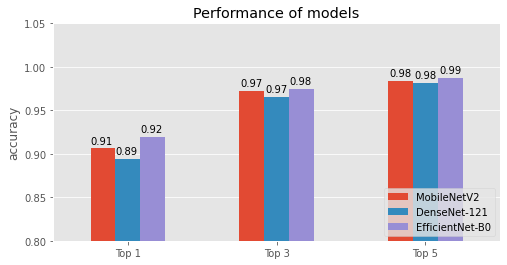

In [ ]:
# Plot models comparison
plot_models_comparison(['MobileNetV2', 'DenseNet-121', 'EfficientNet-B0'], mobilenet05_score, densenet_score, efficientnet_score)

In [ ]:
plot_comparison(['MobileNetV2', 'DenseNet-121', 'EfficientNet-B0'], mobilenet75_score, densenet_score, efficientnet_score)

In [ ]:
plot_comparison(['MobileNetV2', 'DenseNet-121', 'EfficientNet-B0'], mobilenet1_score, densenet_score, efficientnet_score)

# Pruning

## MobileNet V2

In [ ]:
# Load MobileNetV2 and the amount of params per layer
mobilenet = load_model('mobilenet05.h5')
mobilenet._name='mobilenet'
net='mobilenet'
params_per_layer(mobilenet)

                         Total  Total%
InputLayer                   0    0.00
Conv2D                  636592   76.07
BatchNormalization       37088    4.43
ReLU                         0    0.00
DepthwiseConv2D          32544    3.89
ZeroPadding2D                0    0.00
Add                          0    0.00
GlobalAveragePooling2D       0    0.00
Dropout                      0    0.00
Dense                   130662   15.61


In [ ]:
# Iterative pruning
mobilenet_pruned_scores = prune_net(mobilenet,6)

evaluating base
25/25 [==============================] - 9s 333ms/step - loss: 0.3329 - categorical_accuracy: 0.9066 - top_3_categorical_accuracy: 0.9725 - top_5_categorical_accuracy: 0.9841
Conv1 - Zeros: 0.00%
expanded_conv_project - Zeros: 0.00%
block_1_expand - Zeros: 0.00%
block_1_project - Zeros: 0.00%
block_2_expand - Zeros: 0.00%
block_2_project - Zeros: 0.00%
block_3_expand - Zeros: 0.00%
block_3_project - Zeros: 0.00%
block_4_expand - Zeros: 0.00%
block_4_project - Zeros: 0.00%
block_5_expand - Zeros: 0.00%
block_5_project - Zeros: 0.00%
block_6_expand - Zeros: 0.00%
block_6_project - Zeros: 0.00%
block_7_expand - Zeros: 0.00%
block_7_project - Zeros: 0.00%
block_8_expand - Zeros: 0.00%
block_8_project - Zeros: 0.00%
block_9_expand - Zeros: 0.00%
block_9_project - Zeros: 0.00%
block_10_expand - Zeros: 0.00%
block_10_project - Zeros: 0.00%
block_11_expand - Zeros: 0.00%
block_11_project - Zeros: 0.00%
block_12_expand - Zeros: 0.00%
block_12_project - Zeros: 0.00%
block_13_expa

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


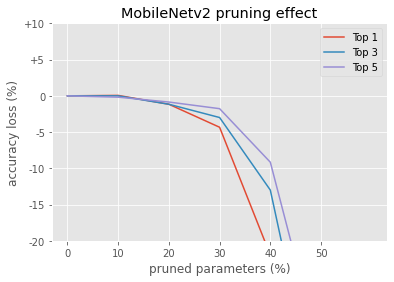

In [ ]:
plot_accuracy_sparsity_curve(mobilenet_pruned_scores, 'MobileNetV2', 'mobilenet-pruning.eps')

## DenseNet121

In [ ]:
# Load DenseNet-121 and the amount of params per layer
densenet = load_model('densenet.h5')
densenet._name='densenet'
net='densenet'
params_per_layer(densenet)

                          Total  Total%
InputLayer                    0    0.00
ZeroPadding2D                 0    0.00
Conv2D                  6870208   96.19
BatchNormalization       167296    2.34
Activation                    0    0.00
MaxPooling2D                  0    0.00
Concatenate                   0    0.00
AveragePooling2D              0    0.00
GlobalAveragePooling2D        0    0.00
Dropout                       0    0.00
Dense                    104550    1.46


In [ ]:
# Iterative pruning
densenet_pruned_scores = prune_net(densenet,6)

evaluating base
25/25 [==============================] - 19s 419ms/step - loss: 0.4621 - categorical_accuracy: 0.8944 - top_3_categorical_accuracy: 0.9658 - top_5_categorical_accuracy: 0.9817
conv1/conv - Zeros: 0.00%
conv2_block1_1_conv - Zeros: 0.00%
conv2_block1_2_conv - Zeros: 0.00%
conv2_block2_1_conv - Zeros: 0.00%
conv2_block2_2_conv - Zeros: 0.00%
conv2_block3_1_conv - Zeros: 0.00%
conv2_block3_2_conv - Zeros: 0.00%
conv2_block4_1_conv - Zeros: 0.00%
conv2_block4_2_conv - Zeros: 0.00%
conv2_block5_1_conv - Zeros: 0.00%
conv2_block5_2_conv - Zeros: 0.00%
conv2_block6_1_conv - Zeros: 0.00%
conv2_block6_2_conv - Zeros: 0.00%
pool2_conv - Zeros: 0.00%
conv3_block1_1_conv - Zeros: 0.00%
conv3_block1_2_conv - Zeros: 0.00%
conv3_block2_1_conv - Zeros: 0.00%
conv3_block2_2_conv - Zeros: 0.00%
conv3_block3_1_conv - Zeros: 0.00%
conv3_block3_2_conv - Zeros: 0.00%
conv3_block4_1_conv - Zeros: 0.00%
conv3_block4_2_conv - Zeros: 0.00%
conv3_block5_1_conv - Zeros: 0.00%
conv3_block5_2_conv -

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


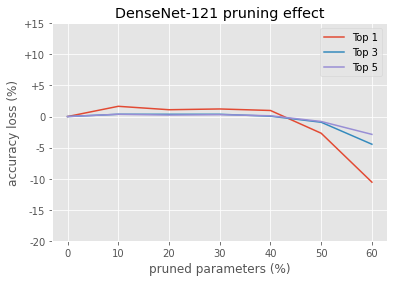

In [ ]:
plot_accuracy_sparsity_curve(densenet_pruned_scores, 'DenseNet-121', 'densenet-pruning.eps')

## EfficientNetB0

In [ ]:
# Load EfficientNet-B0 and the amount of params per layer
efficientnet = load_model('efficientnet.h5')
efficientnet._name='efficientnet'
net='efficientnet'
params_per_layer(efficientnet)

                          Total  Total%
InputLayer                    0    0.00
Rescaling                     0    0.00
Normalization                 7    0.00
ZeroPadding2D                 0    0.00
Conv2D                  3783516   90.51
BatchNormalization        84032    2.01
Activation                    0    0.00
DepthwiseConv2D          182016    4.35
GlobalAveragePooling2D        0    0.00
Reshape                       0    0.00
Multiply                      0    0.00
Dropout                       0    0.00
Add                           0    0.00
Dense                    130662    3.13


In [ ]:
# Iterative pruning
efficientnet_pruned_scores = prune_net(efficientnet,6)

evaluating base
25/25 [==============================] - 17s 354ms/step - loss: 0.3530 - categorical_accuracy: 0.9194 - top_3_categorical_accuracy: 0.9750 - top_5_categorical_accuracy: 0.9872
stem_conv - Zeros: 1.39%
block1a_dwconv - Zeros: 0.35%
block1a_se_reduce - Zeros: 0.00%
block1a_se_expand - Zeros: 0.00%
block1a_project_conv - Zeros: 0.00%
block2a_expand_conv - Zeros: 0.00%
block2a_dwconv - Zeros: 0.00%
block2a_se_reduce - Zeros: 0.00%
block2a_se_expand - Zeros: 0.00%
block2a_project_conv - Zeros: 0.00%
block2b_expand_conv - Zeros: 0.75%
block2b_dwconv - Zeros: 0.62%
block2b_se_reduce - Zeros: 0.00%
block2b_se_expand - Zeros: 0.00%
block2b_project_conv - Zeros: 0.00%
block3a_expand_conv - Zeros: 0.00%
block3a_dwconv - Zeros: 0.00%
block3a_se_reduce - Zeros: 0.00%
block3a_se_expand - Zeros: 0.00%
block3a_project_conv - Zeros: 0.00%
block3b_expand_conv - Zeros: 0.00%
block3b_dwconv - Zeros: 0.00%
block3b_se_reduce - Zeros: 0.00%
block3b_se_expand - Zeros: 0.00%
block3b_project_con

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


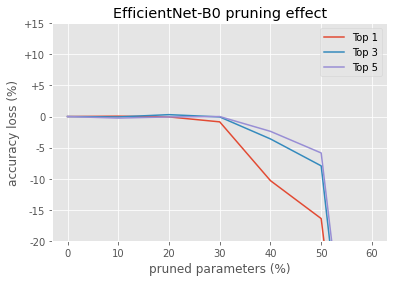

In [ ]:
plot_accuracy_sparsity_curve(efficientnet_pruned_scores, 'EfficientNet-B0', 'efficientnet-pruning.eps')

#Quantization

In [ ]:
MB = 1000000

## MobileNet V2

In [ ]:
# Load pruned MobileNetV2 and set global variable for modified_preprocess_function
net='mobilenet'
mobilenet = load_model('mobilenet20.h5')

In [ ]:
# TFlite without quantization
model_to_TFlite_float32(mobilenet,'/content/mobilenet.tflite')
size_mobilenet=os.stat('/content/mobilenet.tflite').st_size/MB
print(size_mobilenet)

INFO:tensorflow:Assets written to: /tmp/tmpjjy9e4ec/assets


INFO:tensorflow:Assets written to: /tmp/tmpjjy9e4ec/assets


3.269356


In [ ]:
# TFlite with float16 quantization
model_to_TFlite_float16(mobilenet,'/content/mobilenet_float16.tflite')
size_mobilenet_float16=os.stat('/content/mobilenet_float16.tflite').st_size/MB
print(size_mobilenet_float16)

INFO:tensorflow:Assets written to: /tmp/tmp6o8wmuee/assets


INFO:tensorflow:Assets written to: /tmp/tmp6o8wmuee/assets


1.668464


In [ ]:
# TFlite with dynamic range quantization
model_to_TFlite_dynamic(mobilenet,'/content/mobilenet_dynamic.tflite')
size_mobilenet_tflite_dynamic=os.stat('/content/mobilenet_dynamic.tflite').st_size/MB
print(size_mobilenet_tflite_dynamic)

INFO:tensorflow:Assets written to: /tmp/tmptv5x1y74/assets


INFO:tensorflow:Assets written to: /tmp/tmptv5x1y74/assets


1.066128


In [ ]:
# TFlite without quantization performance
top1_mn, top3_mn, top5_mn, avg_time = tflite_performance("/content/mobilenet.tflite", test, modified_preprocess)

print(top1_mn)
print(top3_mn)
print(top5_mn)
print(avg_time)

Interpreter allocate...
Start evaluation...



0.894993894993895
0.960927960927961
0.9755799755799756
0.010584481178768097


In [ ]:
# TFlite with float16 quantization performance
top1_mn, top3_mn, top5_mn, avg_time = tflite_performance("/content/mobilenet_float16.tflite", test, modified_preprocess)

print(top1_mn)
print(top3_mn)
print(top5_mn)
print(avg_time)

Interpreter allocate...
Start evaluation...



0.894993894993895
0.9615384615384616
0.9755799755799756
0.010403180005931737


In [ ]:
# TFlite with dynamic range quantization performance
top1_mn_q, top3_mn_q, top5_mn_q, avg_time = tflite_performance("/content/mobilenet_dynamic.tflite", test, modified_preprocess)

print(top1_mn_q)
print(top3_mn_q)
print(top5_mn_q)
print(avg_time)

Interpreter allocate...
Start evaluation...



0.8925518925518926
0.9590964590964591
0.9743589743589743
0.2558672043866727


## DenseNet121

In [ ]:
# Load pruned DenseNet-121 and set global variable for modified_preprocess_function
net='densenet'
densenet = load_model('densenet40.h5')

In [ ]:
# TFlite without quantization
model_to_TFlite_float32(densenet,'/content/densenet.tflite')
size_densenet=os.stat('/content/densenet.tflite').st_size/MB
print(size_densenet)

INFO:tensorflow:Assets written to: /tmp/tmp7xfkyrv5/assets
28.305224


In [ ]:
# TFlite with float16 quantization
model_to_TFlite_float16(densenet,'/content/densenet_float16.tflite')
size_densenet_float16=os.stat('/content/densenet_float16.tflite').st_size/MB
print(size_densenet_float16)

INFO:tensorflow:Assets written to: /tmp/tmp14czfant/assets


INFO:tensorflow:Assets written to: /tmp/tmp14czfant/assets


14.24648


In [ ]:
# TFlite with dynamic range quantization
model_to_TFlite_dynamic(densenet,'/content/densenet_dynamic.tflite')
size_densenet_tflite_dynamic=os.stat('/content/densenet_dynamic.tflite').st_size/MB
print(size_densenet_tflite_dynamic)

INFO:tensorflow:Assets written to: /tmp/tmpnpbvz5w0/assets


INFO:tensorflow:Assets written to: /tmp/tmpnpbvz5w0/assets


7.596864


In [ ]:
# TFlite without quantization performance
top1_dn, top3_dn, top5_dn, avg_time = tflite_performance("/content/densenet.tflite", test, modified_preprocess)

print(top1_dn)
print(top3_dn)
print(top5_dn)
print(avg_time)

Interpreter allocate...
Start evaluation...



0.9041514041514042
0.9664224664224664
0.9829059829059829
0.11237390967079135


In [ ]:
# TFlite with float16 quantization performance
top1_dn, top3_dn, top5_dn, avg_time = tflite_performance("/content/densenet_float16.tflite", test, modified_preprocess)

print(top1_dn)
print(top3_dn)
print(top5_dn)
print(avg_time)

Interpreter allocate...
Start evaluation...



0.9035409035409036
0.9664224664224664
0.9829059829059829
0.11188813720139537


In [ ]:
# TFlite with dynamic range quantization performance
top1_dn, top3_dn, top5_dn, avg_time = tflite_performance("/content/densenet_dynamic.tflite", test, modified_preprocess)

print(top1_dn)
print(top3_dn)
print(top5_dn)
print(avg_time)

Interpreter allocate...
Start evaluation...


7.353041887283325
7.33837103843689
7.329078197479248
7.342390775680542
7.384969234466553
7.420409202575684
7.372324466705322
7.304019212722778
7.384738206863403
7.352729797363281
7.327054023742676
7.30651593208313
7.3187830448150635
7.345518350601196
7.325922966003418
7.343223810195923
7.388835430145264


KeyboardInterrupt: ignored

## EfficientNetB0

In [ ]:
# Load pruned EfficientNet-B0 and set global variable for modified_preprocess_function
net='efficientnet'
efficientnet = load_model('efficientnet30.h5')

In [ ]:
# TFlite without quantization
model_to_TFlite_float32(efficientnet,'/content/efficientnet.tflite')
size_efficient=os.stat('/content/efficientnet.tflite').st_size/MB
print(size_efficient)

INFO:tensorflow:Assets written to: /tmp/tmp01pg9i00/assets


INFO:tensorflow:Assets written to: /tmp/tmp01pg9i00/assets


16.556152


In [ ]:
# TFlite with float16 quantization
model_to_TFlite_float16(efficientnet,'/content/efficientnet_float16.tflite')
size_efficient_float16=os.stat('/content/efficientnet_float16.tflite').st_size/MB
print(size_efficient_float16)

INFO:tensorflow:Assets written to: /tmp/tmp7y7w4tqs/assets


INFO:tensorflow:Assets written to: /tmp/tmp7y7w4tqs/assets


8.356032


In [ ]:
# TFlite with dynamic range quantization
model_to_TFlite_dynamic(efficientnet,'/content/efficientnet_dynamic.tflite')
size_efficient_dynamic=os.stat('/content/efficientnet_dynamic.tflite').st_size/MB
print(size_efficient_dynamic)

INFO:tensorflow:Assets written to: /tmp/tmp0_g8yt77/assets


INFO:tensorflow:Assets written to: /tmp/tmp0_g8yt77/assets


4.92072


In [ ]:
# TFlite without quantization performance
top1_en, top3_en, top5_en, avg_time = tflite_performance("/content/efficientnet.tflite", test, modified_preprocess)

print(top1_en)
print(top3_en)
print(top5_en)
print(avg_time)

Interpreter allocate...
Start evaluation...



0.9108669108669109
0.9743589743589743
0.9871794871794872
0.08201528527070023


In [ ]:
# TFlite with float16 quantization performance
top1_en, top3_en, top5_en, avg_time = tflite_performance("/content/efficientnet_float16.tflite", test, modified_preprocess)

print(top1_en)
print(top3_en)
print(top5_en)
print(avg_time)

Interpreter allocate...
Start evaluation...



0.9114774114774115
0.9743589743589743
0.9871794871794872
0.0813270813088423


In [ ]:
# TFlite with dynamic range quantization performance
top1_en, top3_en, top5_en, avg_time = tflite_performance("/content/efficientnet_dynamic.tflite", test, modified_preprocess)

print(top1_en)
print(top3_en)
print(top5_en)
print(avg_time)

Interpreter allocate...
Start evaluation...



0.9133089133089133
0.9725274725274725
0.9853479853479854
1.1607421253772592


## Quantized models comparison

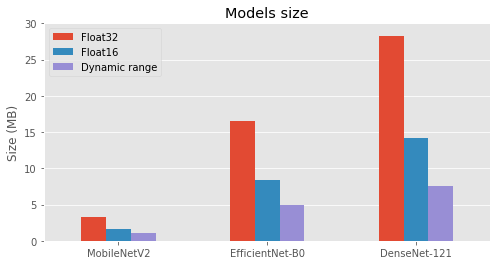

In [ ]:
# Plot quantized models size
mn_float32 = os.stat('/content/mobilenet.h5').st_size/MB
mn_float16 = os.stat('/content/mobilenet_float16.h5').st_size/MB
mn_dynamic = os.stat('/content/mobilenet_dynamic.h5').st_size/MB

dn_float32 = os.stat('/content/densenet.h5').st_size/MB
dn_float16 = os.stat('/content/densenet_float16.h5').st_size/MB
dn_dynamic = os.stat('/content/densenet_dynamic.h5').st_size/MB

en_float32 = os.stat('/content/efficientnet.h5').st_size/MB
en_float16 = os.stat('/content/efficientnet_float16.h5').st_size/MB
en_dynamic = os.stat('/content/efficientnet_dynamic.h5').st_size/MB

labels = ['MobileNetV2', 'EfficientNet-B0', 'DenseNet-121']
mn = [mn_float32, mn_float16, mn_dynamic]
dn = [dn_float32, dn_float16, dn_dynamic]
en = [en_float32, en_float16, en_dynamic]
plot_quantization_size(labels, mn, dn, en, "quantization.eps")